In [1]:
import matplotlib.pyplot as plt
plt.show()

In [3]:
import matplotlib.pyplot as plt
import os, sys
from typing import Iterable, Dict, List, Callable, Tuple, Union, List

import numpy as np
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.nn.functional as F

sys.path.append('../../')
from dataset import ACDCDataset, MNMDataset
from model.unet import UNet2D
from model.ae import AE
from model.dae import resDAE, AugResDAE
from model.wrapper import Frankenstein, ModelAdapter
from losses import DiceScoreMMS
from utils import  epoch_average, UMapGenerator



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [4]:
### - datasets
#acdc_train = ACDCDataset(data='val')



debug = False
loader = {}
vendor = 'A'

mnm_a = MNMDataset(vendor=vendor, debug=debug)
mnm_a_loader = DataLoader(mnm_a, batch_size=1, shuffle=False, drop_last=False)


loading dataset
loading all case properties


In [6]:
### - init unets
# U-Nets
ROOT = '../../../'
middle = 'unet8_'
pre = 'acdc'
unet_names = [f'{pre}_{middle}{i}' for i in range(10)]
unets = []
for name in unet_names:
    model_path = f'{ROOT}pre-trained-tmp/trained_UNets/{name}_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    n_chans_out = 4
    unet = UNet2D(n_chans_in=1, 
                  n_chans_out=n_chans_out, 
                  n_filters_init=8, 
                  dropout=False)
    unet.load_state_dict(state_dict)
    unets.append(unet)

In [7]:
### Init two models for UNet 0, Reconstruction and Residual

# init models
posts = ['localAug_multiImgSingleView_res_balanced_same', 'localAug_multiImgSingleView_recon_balanced_same']
residuals = [True, False]
disabled_ids = ['shortcut0', 'shortcut1', 'shortcut2']
models = []
for i, (post, residual) in enumerate(zip(posts, residuals)):
    DAEs = nn.ModuleDict({'up3': AugResDAE(in_channels = 64, 
                                        in_dim      = 32,
                                        latent_dim  = 256,
                                        depth       = 3,
                                        block_size  = 4,
                                        residual    = residual),
                         })


    for layer_id in disabled_ids:
        DAEs[layer_id] = nn.Identity()
    
    model = Frankenstein(seg_model=unet,
                         transformations=DAEs,
                         disabled_ids=disabled_ids,
                         copy=True)
    model_path = f'{ROOT}pre-trained-tmp/trained_AEs/acdc_AugResDAE1_{post}_best.pt'
    #model_path = f'{ROOT}pre-trained-tmp/trained_AEs/{pre}_resDAE{i}_{post}_best.pt'
    #model_path = f'{ROOT}pre-trained-tmp/trained_AEs/acdc_epinet_CE-only_prior-1_best.pt'localAug_multiImgSingleView_res
    #model_path = f'{ROOT}pre-trained-tmp/trained_AEs/acdc_resDAE0_venus_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    model.load_state_dict(state_dict)
    # Remove trainiung hooks, add evaluation hooks
    model.remove_all_hooks()        
    model.hook_inference_transformations(model.transformations,
                               n_samples=1)
    # Put model in evaluation state
    model.eval()
    model.freeze_seg_model()
    models.append(model)

In [34]:
# init 
umap_generator_AE = UMapGenerator(method='mse', net_out='mms')

# itertatively make samples
for i in range(0, 50):
    # get data
    data = mnm_a[i * 10]
    img_original = data['input'].unsqueeze(0)
#     img_augmented = data['data']
    mask = data['target'].unsqueeze(0)
    mask[mask < 0] = 0
    
        # UNet predictions
#     input_batch = torch.cat([data['data_orig'], data['data']], dim=0)
    unet_output = unets[1](img_original)
    pred = torch.argmax(unet_output, dim=1, keepdims=True)
    err_map = (pred != mask)
    #pred_unet = fo.Segmentation(mask=pred[0].squeeze().numpy())
    #error_unet = fo.Segmentation(mask=err_map.squeeze().numpy())
#     sample_augmented[f'pred_unet'] = fo.Segmentation(mask=pred[1].squeeze().numpy())
    
    # UNet predictions with feature resampling
    res_model_output_original       = models[0](img_original)
    res_model_pred_original         = torch.argmax(res_model_output_original[1], dim=0, keepdims=False)
    #res_pred_ae = fo.Segmentation(mask=res_model_pred_original.squeeze().numpy())
    res_model_umap                  = umap_generator_AE(res_model_output_original)
    #res_umap_ae    = fo.Heatmap(map=res_model_umap.squeeze().numpy())
    
#     res_model_output_augmented       = models[0](data['data'])
#     res_model_pred_augmented         = torch.argmax(res_model_output_augmented[1], dim=0, keepdims=False)
#     sample_augmented[f'res_pred_ae'] = fo.Segmentation(mask=res_model_pred_augmented.squeeze().numpy())
    
    rec_model_output_original       = models[1](img_original)
    rec_model_pred_original         = torch.argmax(rec_model_output_original[1], dim=0, keepdims=False)
    #sample_original[f'rec_pred_ae'] = fo.Segmentation(mask=rec_model_pred_original.squeeze().numpy())
    rec_model_umap                  = umap_generator_AE(rec_model_output_original)
    #sample_original[f'rec_umap_ae']    = fo.Heatmap(map=rec_model_umap.squeeze().numpy())

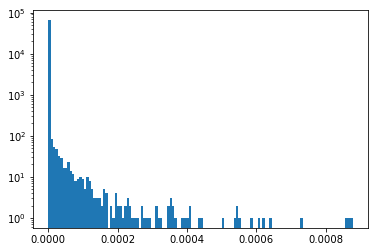

In [35]:
_ = plt.hist(torch.clamp(rec_model_umap, 0, 100).flatten().numpy(), bins=128)
plt.yscale('log')
plt.show()

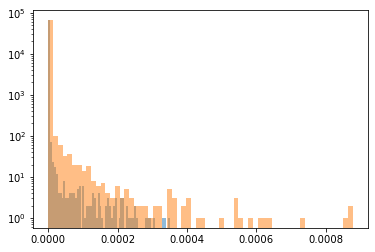

In [44]:
_ = plt.hist(res_model_umap.flatten().numpy(), bins=64, alpha=0.5)
_ = plt.hist(rec_model_umap.flatten().numpy(), bins=64, alpha=0.5)

plt.yscale('log')
plt.show()

In [37]:
rec_model_umap.max()

tensor(0.0009)